# Profiling

The performance measurements for the action-rules package were conducted using the Scalene profiler, a high-precision CPU, GPU, and memory profiler specifically designed for Python. Detailed profiling reports, which provide insights into the package's efficiency and resource usage, can be found in these directories:

* pandas cpu array (Numpy Array)
* pandas cpu sparse (SciPy Sparse M.)
* pandas gpu array (Cupy Array)
* pandas gpu sparse (Cupyx Sparse M.)

## Statistics (Average + Std Dev)
Each measurement was conducted 10 times; below, you can find the summary statistics:

In [3]:
import json
import statistics
from pathlib import Path

import numpy as np
import pandas as pd

PROFILE_FOLDERS = {
    "Numpy Array": "pandas_cpu_array",
    "SciPy Sparse M.": "pandas_cpu_sparse",
    "CPU Bitset": "pandas_cpu_bitset",
    "CuPy Array": "pandas_gpu_array",
    "CuPyx Sparse M.": "pandas_gpu_sparse",
}

base_dir = Path.cwd()
if not (base_dir / "pandas_cpu_array").exists():
    repo_profile_dir = (Path.cwd() / "notebooks" / "profiling").resolve()
    if repo_profile_dir.exists():
        base_dir = repo_profile_dir


def _gpu_peak_from_report(report: dict) -> float:
    peak = 0.0
    for file_data in report.get("files", {}).values():
        for line in file_data.get("lines", []):
            if isinstance(line, dict):
                value = float(line.get("n_gpu_peak_memory_mb", 0.0) or 0.0)
                if value > peak:
                    peak = value
    return peak


def folder_stats(folder: Path) -> dict:
    reports = sorted(folder.glob("scalene_report_*.json"))
    if not reports:
        return {
            "runs": 0,
            "GPU Memory (MB)": np.nan,
            "GPU Std Dev": np.nan,
            "RAM (MB)": np.nan,
            "RAM Std Dev": np.nan,
            "Time (s)": np.nan,
            "Time Std Dev": np.nan,
        }

    times = []
    rams = []
    gpus = []

    for report_path in reports:
        report = json.loads(report_path.read_text(encoding="utf-8"))
        times.append(float(report.get("elapsed_time_sec", 0.0) or 0.0))
        rams.append(float(report.get("max_footprint_mb", 0.0) or 0.0))
        gpus.append(_gpu_peak_from_report(report))

    return {
        "runs": len(reports),
        "GPU Memory (MB)": statistics.mean(gpus),
        "GPU Std Dev": statistics.pstdev(gpus),
        "RAM (MB)": statistics.mean(rams),
        "RAM Std Dev": statistics.pstdev(rams),
        "Time (s)": statistics.mean(times),
        "Time Std Dev": statistics.pstdev(times),
    }


rows = []
for display_name, folder_name in PROFILE_FOLDERS.items():
    stats = folder_stats(base_dir / folder_name)
    stats["Type"] = display_name
    rows.append(stats)

stats_df = pd.DataFrame(rows)[
    [
        "Type",
        "runs",
        "GPU Memory (MB)",
        "GPU Std Dev",
        "RAM (MB)",
        "RAM Std Dev",
        "Time (s)",
        "Time Std Dev",
    ]
]

print(f"Using profiling directory: {base_dir}")
display(stats_df.round(3))


Statistics for numpy_array:
  GPU: Average = 0.00, Std Dev = 0.00
  RAM: Average = 5915.60, Std Dev = 2.94
  Time: Average = 22.58, Std Dev = 3.30

Statistics for scipy_sparse:
  GPU: Average = 0.00, Std Dev = 0.00
  RAM: Average = 7148.10, Std Dev = 4.01
  Time: Average = 223.81, Std Dev = 0.43

Statistics for cupy_array:
  GPU: Average = 9288.40, Std Dev = 143.31
  RAM: Average = 123.90, Std Dev = 1.04
  Time: Average = 12.37, Std Dev = 7.61

Statistics for cupyx_sparse:
  GPU: Average = 1765.00, Std Dev = 4.84
  RAM: Average = 125.20, Std Dev = 1.17
  Time: Average = 38.57, Std Dev = 3.82



## Graph with average values

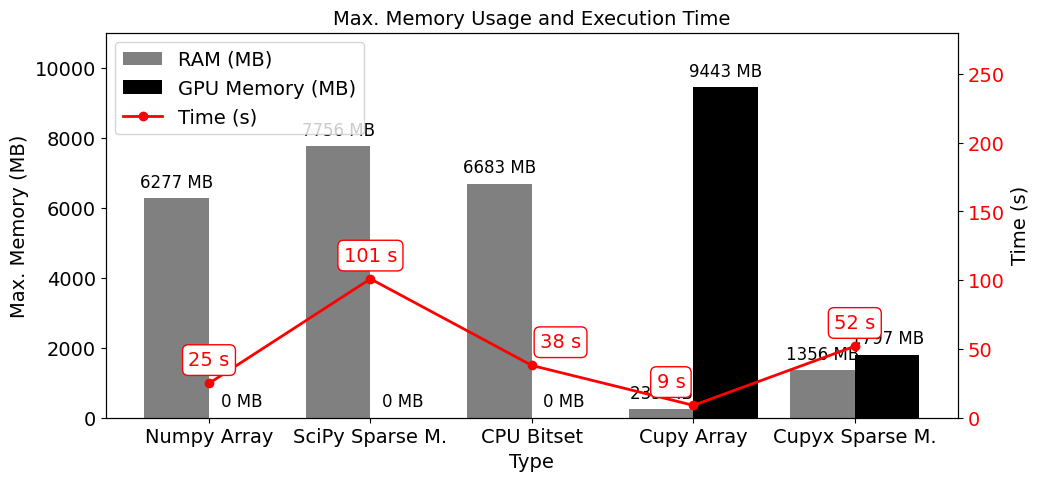

In [17]:
import matplotlib.pyplot as plt
import numpy as np

df = stats_df.dropna(subset=["RAM (MB)", "GPU Memory (MB)", "Time (s)"]).copy()

bar_width = 0.4
bar_positions = np.arange(len(df))

fig, ax1 = plt.subplots(figsize=(11, 5))

ax1.bar(bar_positions - bar_width / 2, df["RAM (MB)"], bar_width, color="gray", label="RAM (MB)")
ax1.bar(bar_positions + bar_width / 2, df["GPU Memory (MB)"], bar_width, color="black", label="GPU Memory (MB)")

ax1.set_ylabel("Max. Memory (MB)", fontsize=14)
ax1.set_xlabel("Type", fontsize=14)
ax1.set_xticks(bar_positions)
ax1.set_xticklabels(df["Type"], fontsize=12)
ax1.tick_params(axis="y", labelsize=12)

max_memory = max(float(df["RAM (MB)"].max()), float(df["GPU Memory (MB)"].max()))
ax1.set_ylim(0, max_memory * 1.2 if max_memory > 0 else 1)

for i in range(len(df)):
    ax1.text(bar_positions[i] - bar_width / 2, df["RAM (MB)"].iloc[i] + max_memory * 0.02, f"{df['RAM (MB)'].iloc[i]:.1f} MB", ha="center", va="bottom", color="black", fontsize=10)
    ax1.text(bar_positions[i] + bar_width / 2, df["GPU Memory (MB)"].iloc[i] + max_memory * 0.02, f"{df['GPU Memory (MB)'].iloc[i]:.1f} MB", ha="center", va="bottom", color="black", fontsize=10)

ax2 = ax1.twinx()
ax2.plot(bar_positions, df["Time (s)"], color="red", marker="o", linestyle="-", linewidth=2, label="Time (s)")
ax2.set_ylabel("Time (s)", fontsize=14)
ax2.tick_params(axis="y", labelcolor="red", labelsize=12)

max_time = float(df["Time (s)"].max())
ax2.set_ylim(0, max_time * 1.2 if max_time > 0 else 1)

for i, time_value in enumerate(df["Time (s)"]):
    ax2.text(bar_positions[i], time_value + max_time * 0.03, f"{time_value:.2f} s", ha="center", va="bottom", color="red", fontsize=10)

fig.tight_layout()
fig.legend(loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.08), frameon=False)
plt.savefig("memory_and_time.png", format="png", dpi=300)
plt.show()


## Graph with average values and std dev

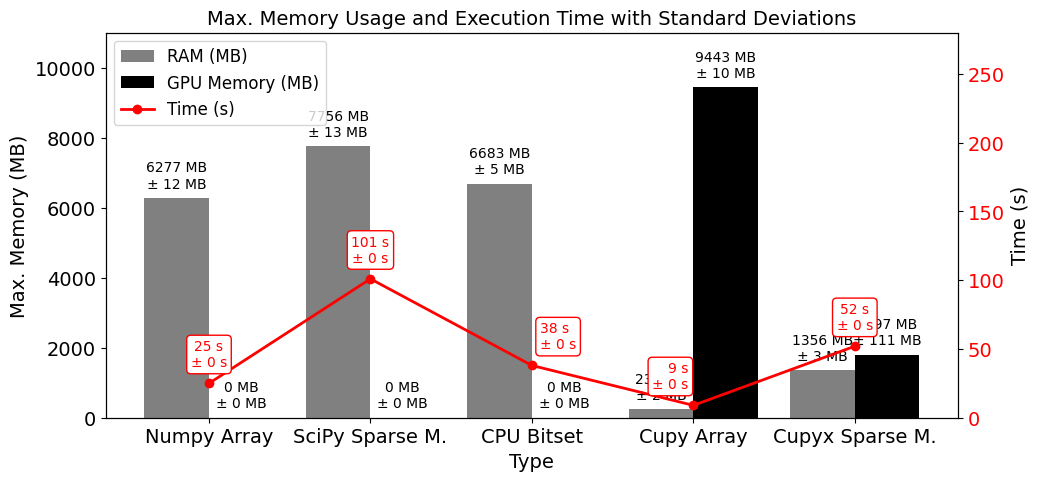

In [16]:
import matplotlib.pyplot as plt
import numpy as np

df = stats_df.dropna(subset=["RAM (MB)", "GPU Memory (MB)", "Time (s)"]).copy()

bar_width = 0.4
bar_positions = np.arange(len(df))

fig, ax1 = plt.subplots(figsize=(11, 5))

ax1.bar(bar_positions - bar_width / 2, df["RAM (MB)"], bar_width, color="gray", label="RAM (MB)")
ax1.bar(bar_positions + bar_width / 2, df["GPU Memory (MB)"], bar_width, color="black", label="GPU Memory (MB)")

ax1.set_ylabel("Max. Memory (MB)", fontsize=14)
ax1.set_xlabel("Type", fontsize=14)
ax1.set_xticks(bar_positions)
ax1.set_xticklabels(df["Type"], fontsize=12)
ax1.tick_params(axis="y", labelsize=12)

max_memory = max(float(df["RAM (MB)"].max()), float(df["GPU Memory (MB)"].max()))
ax1.set_ylim(0, max_memory * 1.25 if max_memory > 0 else 1)

for i in range(len(df)):
    ram = df["RAM (MB)"].iloc[i]
    ram_std = df["RAM Std Dev"].iloc[i]
    gpu = df["GPU Memory (MB)"].iloc[i]
    gpu_std = df["GPU Std Dev"].iloc[i]
    ax1.text(bar_positions[i] - bar_width / 2, ram + max_memory * 0.02, f"{ram:.1f} MB\n+/- {ram_std:.1f} MB", ha="center", va="bottom", color="black", fontsize=9)
    ax1.text(bar_positions[i] + bar_width / 2, gpu + max_memory * 0.02, f"{gpu:.1f} MB\n+/- {gpu_std:.1f} MB", ha="center", va="bottom", color="black", fontsize=9)

ax2 = ax1.twinx()
ax2.plot(bar_positions, df["Time (s)"], color="red", marker="o", linestyle="-", linewidth=2, label="Time (s)")
ax2.set_ylabel("Time (s)", fontsize=14)
ax2.tick_params(axis="y", labelcolor="red", labelsize=12)

max_time = float(df["Time (s)"].max())
ax2.set_ylim(0, max_time * 1.3 if max_time > 0 else 1)

for i in range(len(df)):
    time_value = df["Time (s)"].iloc[i]
    time_std = df["Time Std Dev"].iloc[i]
    ax2.text(bar_positions[i], time_value + max_time * 0.03, f"{time_value:.2f} s\n+/- {time_std:.2f} s", ha="center", va="bottom", color="red", fontsize=9)

fig.tight_layout()
fig.legend(loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.08), frameon=False)
plt.savefig("memory_and_time_with_std.png", format="png", dpi=300)
plt.show()
